# AI Quest 2021 PBL06

## データダウンロード

### signateのtoken登録

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install signate | tail -n 1

import os, shutil

gdrive='/content/drive/MyDrive/Colab Notebooks'
token=f'{gdrive}/signate.json'
deploy='/root/.signate'
os.makedirs(deploy, exist_ok=True)
shutil.copyfile(token, f'{deploy}/signate.json')

'/root/.signate/signate.json'

In [3]:
download_flag = False

### PBLリスト表示

In [4]:
if download_flag:
    !signate list | grep PBL

### PBL06 AI課題ファイルリスト表示

In [5]:
competition_id=527
if download_flag:
    !signate files --competition-id={competition_id}

### PBL06 AI課題ダウンロード

In [6]:
own_dir = f'{gdrive}/AI_Quest_2021/PBL06'
data_dir = f'{own_dir}/data'

In [7]:
if download_flag:
    os.makedirs(own_dir, exist_ok=True)
    !signate download --competition-id={competition_id} --path="{data_dir}/"

### zipファイルの解凍

In [8]:
if download_flag:
    !unzip -o "{data_dir}/train.zip" -d "{data_dir}"
    !unzip -o "{data_dir}/test.zip" -d "{data_dir}"

## 前処理

### データ読み込み

In [9]:
raw_data_read_flag = False

In [10]:
import glob
import pandas as pd

if raw_data_read_flag:
    normal_fps = glob.glob(f'{data_dir}/train/normal/*')
    anomaly_fps = glob.glob(f'{data_dir}/train/anomaly/*')
    test_fps = glob.glob(f'{data_dir}/test/*')
    sample_submit = pd.read_csv(f'{data_dir}/sample_submission.csv', header=None)
    len(normal_fps), len(anomaly_fps), len(test_fps)

In [11]:
sampling_rate = 50000  # 50kHz
sampling_rate

50000

In [12]:
def read_csv_wave(fps):
    dfs = []
    for fp in fps:
        df = pd.read_csv(fp, header=None)
        df.index /= sampling_rate
        df = df.rename(columns=lambda s: f'ACC{s+1}')
        df = df.rename(columns={'ACC7': 'AE'})
        dfs.append(df)
    sum_df = pd.concat(dfs, axis=1, keys=[os.path.basename(fp) for fp in fps])
    sum_df = sum_df.sort_index(axis=1, level=0)
    sum_df = sum_df.interpolate(limit_direction='both')
    return sum_df

In [13]:
%%time
if raw_data_read_flag:
    norm_df = read_csv_wave(normal_fps)
    anom_df = read_csv_wave(anomaly_fps)
    test_df = read_csv_wave(test_fps)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


#### 波形データをpickleで保存

In [14]:
import pickle

if raw_data_read_flag:
    dct = {
        'norm.pickle': norm_df,
        'anom.pickle': anom_df,
        'test.pickle': test_df,
    }
    for file_name, df in dct.items():
        with open(f'{data_dir}/{file_name}', mode='wb') as f:
            pickle.dump(df, f)

#### 波形データをpickleから読み込み

In [15]:
%%time
import pickle

if not raw_data_read_flag:
    with open(f'{data_dir}/norm.pickle', mode='rb') as f:
        norm_df = pickle.load(f)
    with open(f'{data_dir}/anom.pickle', mode='rb') as f:
        anom_df = pickle.load(f)
    with open(f'{data_dir}/test.pickle', mode='rb') as f:
        test_df = pickle.load(f)

CPU times: user 414 ms, sys: 3.53 s, total: 3.94 s
Wall time: 11.3 s


### tsfreshによる時系列データの特徴量生成

#### tsfresh解析用にデータ構成変更

In [17]:
tsfresh_run_flag = False

In [18]:
if tsfresh_run_flag:
    rename_dict = {
        'level_0': 'time',
        'level_1': 'id',
    }
    for_tsfresh_dfs = []
    for df in [norm_df, anom_df, test_df]:
        temp_df = df.stack(level=0)
        temp_df = temp_df.sort_index(level=1)
        temp_df = temp_df.reset_index()
        temp_df = temp_df.rename(columns=rename_dict)
        for_tsfresh_dfs.append(temp_df)
    for_tsfresh_df = pd.concat(for_tsfresh_dfs)
    for_tsfresh_df = for_tsfresh_df.reset_index(drop=True)
    for_tsfresh_df

#### tsfreshインストール

In [19]:
if tsfresh_run_flag:
    !pip install tsfresh | tail -n 1

#### tsfresh実行（すごい時間かかる） & csvファイル保存

In [20]:
%%time
if tsfresh_run_flag:
    from tsfresh import extract_features

    extracted_features = []
    # 一括で実行すると進捗が分からなかったため、id毎に解析を実行
    for id_name in df['id'].unique():
        one_df = df[df['id'] == id_name]
        print(id_name)
        extracted_features.append(extract_features(one_df[::3], column_id='id', column_sort='time'))

    tsfresh_df = pd.concat(extracted_features)
    tsfresh_df.to_csv(f'{data_dir}/pbl06_tsfresh.csv')
    tsfresh_df

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [22]:
%%time
if not tsfresh_run_flag:
    tsfresh_df = pd.read_csv(f'{data_dir}/pbl06_tsfresh.csv', index_col=0)
tsfresh_df

CPU times: user 3.16 s, sys: 105 ms, total: 3.27 s
Wall time: 3.62 s


### nanを含む列の削除 & target列追加 & カラム名修正

In [23]:
import re

df = tsfresh_df.copy()
df = df.dropna(axis=1)
df.loc[df.index.str.contains('normal'), 'target'] = 0
df.loc[df.index.str.contains('anomaly'), 'target'] = 1
df = df.rename(columns=lambda x:re.sub('[^A-Za-z0-9_\-\.]+', '', x))
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

,ACC1__variance_larger_than_standard_deviation,ACC1__has_duplicate_max,ACC1__has_duplicate_min,ACC1__has_duplicate,ACC1__sum_values,ACC1__abs_energy,ACC1__mean_abs_change,ACC1__mean_change,ACC1__mean_second_derivative_central,ACC1__median,ACC1__mean,ACC1__length,ACC1__standard_deviation,ACC1__variation_coefficient,ACC1__variance,ACC1__skewness,ACC1__kurtosis,ACC1__root_mean_square,ACC1__absolute_sum_of_changes,ACC1__longest_strike_below_mean,ACC1__longest_strike_above_mean,ACC1__count_above_mean,ACC1__count_below_mean,ACC1__last_location_of_maximum,ACC1__first_location_of_maximum,ACC1__last_location_of_minimum,ACC1__first_location_of_minimum,ACC1__percentage_of_reoccurring_values_to_all_values,ACC1__percentage_of_reoccurring_datapoints_to_all_datapoints,ACC1__sum_of_reoccurring_values,ACC1__sum_of_reoccurring_data_points,ACC1__ratio_value_number_to_time_series_length,ACC1__sample_entropy,ACC1__maximum,ACC1__minimum,ACC1__benford_correlation,ACC1__time_reversal_asymmetry_statistic__lag_1,ACC1__time_reversal_asymmetry_statistic__lag_2,ACC1__time_reversal_asymmetry_statistic__lag_3,ACC1__c3__lag_1,...,ACC4__energy_ratio_by_chunks__num_segments_10__segment_focus_4,ACC4__energy_ratio_by_chunks__num_segments_10__segment_focus_5,ACC4__energy_ratio_by_chunks__num_segments_10__segment_focus_6,ACC4__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ACC4__energy_ratio_by_chunks__num_segments_10__segment_focus_8,ACC4__energy_ratio_by_chunks__num_segments_10__segment_focus_9,ACC4__ratio_beyond_r_sigma__r_0.5,ACC4__ratio_beyond_r_sigma__r_1,ACC4__ratio_beyond_r_sigma__r_1.5,ACC4__ratio_beyond_r_sigma__r_2,ACC4__ratio_beyond_r_sigma__r_2.5,ACC4__ratio_beyond_r_sigma__r_3,ACC4__ratio_beyond_r_sigma__r_5,ACC4__ratio_beyond_r_sigma__r_6,ACC4__ratio_beyond_r_sigma__r_7,ACC4__ratio_beyond_r_sigma__r_10,ACC4__count_above__t_0,ACC4__count_below__t_0,ACC4__lempel_ziv_complexity__bins_2,ACC4__lempel_ziv_complexity__bins_3,ACC4__lempel_ziv_complexity__bins_5,ACC4__lempel_ziv_complexity__bins_10,ACC4__lempel_ziv_complexity__bins_100,ACC4__fourier_entropy__bins_2,ACC4__fourier_entropy__bins_3,ACC4__fourier_entropy__bins_5,ACC4__fourier_entropy__bins_10,ACC4__fourier_entropy__bins_100,ACC4__permutation_entropy__dimension_3__tau_1,ACC4__permutation_entropy__dimension_4__tau_1,ACC4__permutation_entropy__dimension_5__tau_1,ACC4__permutation_entropy__dimension_6__tau_1,ACC4__permutation_entropy__dimension_7__tau_1,ACC4__matrix_profile__feature_min__threshold_0.98,ACC4__matrix_profile__feature_max__threshold_0.98,ACC4__matrix_profile__feature_mean__threshold_0.98,ACC4__matrix_profile__feature_median__threshold_0.98,ACC4__matrix_profile__feature_25__threshold_0.98,ACC4__matrix_profile__feature_75__threshold_0.98,target
normal_000.csv,0.0,0.0,0.0,1.0,-100.774624,4904.122394,1.417838,0.000229,0.000096,0.063768,-0.020155,5000.0,0.990161,-49.127483,0.980418,-0.285386,-1.082088,0.990366,7087.772256,2.0,21.0,2596.0,2404.0,0.4862,0.4860,0.3500,0.3498,0.043515,0.0856,98.243235,203.845570,0.9560,1.073304,1.45820,-3.125300,0.862727,0.011657,-0.007533,0.002150,0.170742,...,0.027543,0.070648,0.240254,0.152641,0.057925,0.121656,0.6528,0.3386,0.1466,0.0316,0.0040,0.0000,0.0,0.0,0.0,0.0,0.5086,0.4914,0.02,0.0426,0.0638,0.1100,0.3670,0.079983,0.090729,0.170467,0.215617,0.425614,1.784077,3.042406,4.138607,5.189655,6.195801,3.011393,13.834408,6.947274,6.825240,5.221428,8.388816,0.0
normal_001.csv,0.0,0.0,0.0,1.0,47.963158,4751.054738,1.390188,-0.000277,-0.000156,0.099764,0.009593,5000.0,0.974740,101.613456,0.950119,-0.300469,-1.060336,0.974788,6949.549914,2.0,26.0,2629.0,2371.0,0.2848,0.2846,0.6568,0.6566,0.045293,0.0894,98.070441,206.692082,0.9538,1.109923,1.49060,-2.826800,0.866128,-0.000138,0.004460,-0.001820,0.130125,...,0.012030,0.015385,0.219068,0.188000,0.137018,0.223584,0.6866,0.3718,0.1220,0.0252,0.0036,0.0000,0.0,0.0,0.0,0.0,0.7320,0.2680,0.02,0.0388,0.0696,0.1166,0.3740,0.079983,0.090729,0.136002,0.215617,0.425614,1.784346,3.041508,4.125874,5.159764,6.150489,4

### train test 分割 

In [24]:
train_df = df[df.index.str.contains('normal') | df.index.str.contains('anomaly')]
test_df = df[df.index.str.contains('data')]
train_df.shape, test_df.shape

((440, 5503), (480, 5503))

### train val 分割

In [25]:
from sklearn.model_selection import train_test_split 
X = train_df.drop('target', axis=1)
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((352, 5502), (88, 5502), (352,), (88,))

## モデル構築

### LightGBM

In [27]:
%%time
import lightgbm as lgb

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.flatten()
print(cm)

[[70  0]
 [ 0 18]]


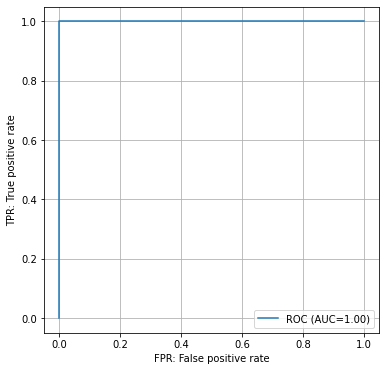

In [29]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.2f})')
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

# 結果の提出

In [33]:
y_test_pred = model.predict(test_df.drop('target', axis=1))
y_test_pred = y_test_pred.astype(int)
print(y_test_pred.sum())
y_test_pred

144


array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [36]:
import os
from datetime import datetime

os.makedirs(f'{own_dir}/submit', exist_ok=True)
submit_dir = f'{own_dir}/submit/{datetime.now().strftime("%y-%m-%d")}'
os.makedirs(submit_dir, exist_ok=True)

In [37]:
sub = pd.read_csv(f"{data_dir}/sample_submission.csv", header=None)
sub.iloc[:,1] = y_test_pred
filepath = f"{submit_dir}/sub_tsfresh_lgb.csv"
sub.to_csv(filepath, index=False, header=False)

In [38]:
%%script echo skipping
!signate submit --competition-id={competition_id} "{filepath}"

skipping
